In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.sparse import eye, spdiags
from scipy.sparse.linalg import spsolve
import networkx as nx
import pylab as pyl
import imageio
import seaborn as sns

Your Python environment should include `numpy`, `scipy`, `matplotlib` and `networkx`

In [2]:
import sys
sys.path.append("./utils")
import graph_utils as gr
import wasserstein_utils as wass
import diffusion_utils as diff

sns.set_context("paper")

# Implementation of Graph class

## Graph class

In [3]:
class Graph(nx.Graph):
    def __init__(self, R, N, graph = None):
        """
        Initialize the mesh from a path
        """
        if graph == None:
            self.G = nx.full_rary_tree(R, N)
        else:
            self.G = graph
        self.nodes = self.G.nodes
        self.edges = self.G.edges
        self.A = self.compute_adj_matrix()
        self.D = None
        self.L = None

# INit from edges list or adjacency dict
    def clear(self):
        self.G.clear()
        self.nodes = None
        self.edges = None

    def get_neighbors(self, node_ind):
        return self.G.adj[node_ind]
    
    def get_degree(self, node_ind):
        return self.G.degree[node_ind]
    
    def get_nodes(self) -> list:
        return list(self.nodes) 

    def get_edges(self) -> list:
        return list(self.edges)
    
    def add_edge(self, node1:int, node2:int):
        self.G.add_edge(node1, node2)
        # Update fields
        self.edges = self.G.edges
        self.nodes = self.G.nodes

    def add_node(self, node:int):
       self.G.add_edge(node)
       # Update fields
       self.edges = self.G.edges
       self.nodes = self.G.nodes

    def compute_adj_matrix(self):
        self.A =  nx.adjacency_matrix(self.G, nodelist=None, dtype=None, weight=None) 
        
    def compute_incidence_matrix(self):
        self.D = nx.incidence_matrix(self.G, nodelist=None, edgelist=None, oriented=False, weight=None)

    def compute_laplacian_matrix(self):
        self.L = nx.normalized_laplacian_matrix(self.G)
        
    def compute_heat_kernel(self,t):
        if self.L == None:
            self.compute_laplacian_matrix()
        return scipy.linalg.expm(-t*self.L.todense())

        
      
    

In [4]:
def diffuse_graph(f, graph:gr.Graph, t, steps = -1):
    """
    Diffuse a function f on a mesh for time t
    
    Input
    --------------
    f       : (n,) - function values
    graph    : Graph - graph on which to diffuse
    t       : float - time for which to diffuse
    
    Output
    --------------
    f_diffuse : (n,) values of f after diffusion
    """
    if graph.A == None:
        graph.compute_adj_matrix()

    graph.compute_laplacian_matrix()
    n_vertices = graph.L.shape[0]
    
    # A MIEUX DEFINIR
    if steps<=0:
        # f_diffuse = scipy.sparse.linalg.spsolve(graph.A + t*graph.L, graph.A@f)
        # f_diffuse = scipy.sparse.linalg.spsolve(eye(n_vertices) - t*graph.L, f)
        degree = [j for (i,j) in nx.degree(graph.G)]
        f_diffuse = scipy.sparse.linalg.spsolve(scipy.sparse.diags(1/np.array(degree))@graph.A, f)
        
        
    else:
        h = t/steps
        f_diffuse = scipy.sparse.linalg.spsolve(eye(n_vertices) - t*graph.L, f)
        
        for i in range(steps):
            f_diffuse = scipy.sparse.linalg.spsolve(eye(n_vertices) - t*graph.L, f)
            # help fix numerical issues
            f_diffuse[f_diffuse<0] = 0
            f_diffuse = f_diffuse / np.sum(f_diffuse) * np.sum(f); 
   
    return f_diffuse

## Kernel function

In [5]:
def kernel(G:gr.Graph, entropy_reg = 0.1, deg = 2):
    n = len(G.nodes)
    dist = np.zeros((n,n))
    for (i,source_node) in enumerate(G.nodes):
        for (j,target_node) in enumerate(G.nodes):
            dist[i,j] = nx.shortest_path_length(G,source = source_node, target = target_node)
    if deg == 1:
        return np.exp(-dist/entropy_reg), dist
    else:
        return np.exp(-dist**2/entropy_reg), dist**2

## Diffusion of a Dirac function

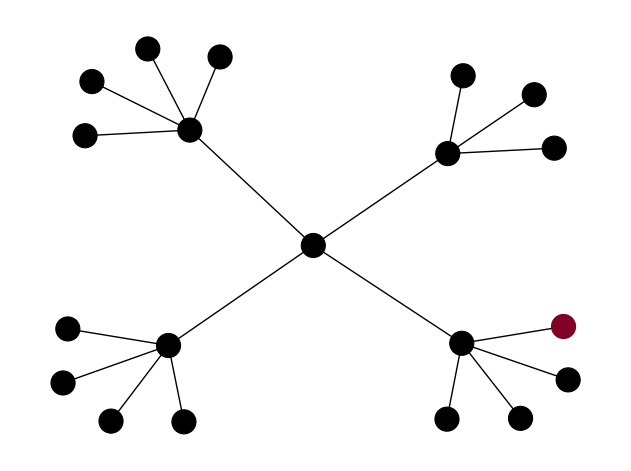

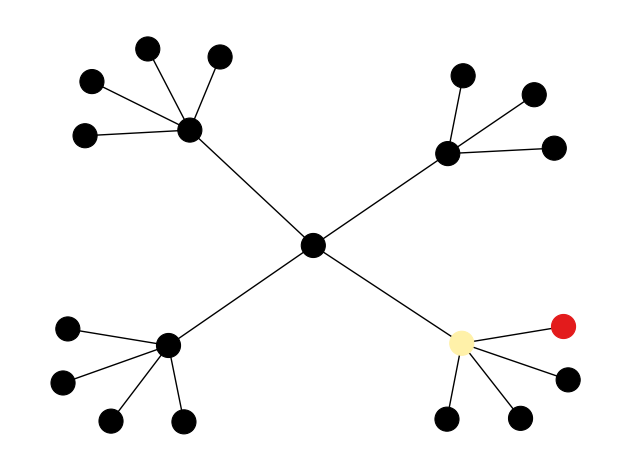

In [6]:
N = 20
R = 4
G = gr.Graph(R,N)

dirac = [0]*N
dirac[N//2] = 1
gr.plot(G.G,dirac)
result_diff = G.compute_heat_kernel(0.3)@np.array(dirac).T
gr.plot(G.G,result_diff)

## Comparison true kernel and heat kernel

Compare the value of the true kernel and the heat kernel as an approximation of the true kernel with geodesic distance ($t\approx \gamma/2$)

For the degree 1 kernel: $K_\gamma \approx \exp{\sqrt{-2t*ln(H_t)/\gamma}}$

For the degree 2 kernel: $K_\gamma \approx H_t^{2t/\gamma}$

In [7]:
N = 20
R = 4
G = gr.Graph(R,N)

entropy_reg = 0.1
t = entropy_reg / 2

K1, dist = gr.kernel(G.G, entropy_reg=entropy_reg, deg = 1)
K2, dist = gr.kernel(G.G, entropy_reg=entropy_reg, deg = 2)
HK = G.compute_heat_kernel(t)

To compare the two kernels we use the Frobenius norm !

Here, the Kernel with degree 2:


In [8]:
norm_kern2 = np.linalg.norm(K2)
diffusion_times = [i*entropy_reg/10 for i in range(1000)]
frob_dist = [np.trace((G.compute_heat_kernel(i*entropy_reg/10)).T@K2)
             /norm_kern2**2 for i in range(1000)]

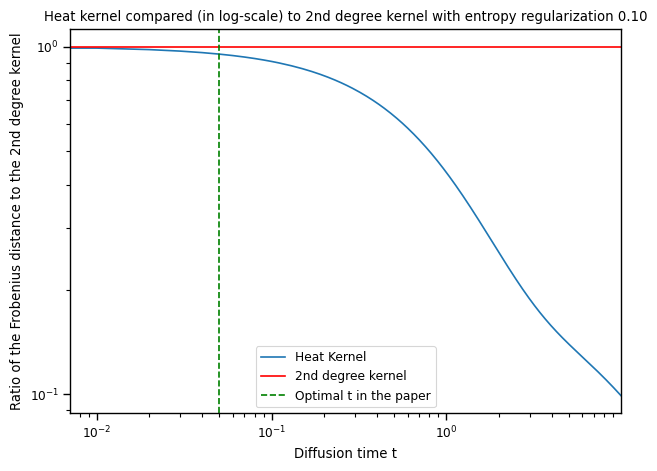

In [9]:
plt.figure()
plt.plot(diffusion_times,frob_dist,label='Heat Kernel')
plt.axhline(y = 1, color = 'r', linestyle = '-',label='2nd degree kernel') 
plt.axvline(x = entropy_reg/2, color ='g', linestyle = '--', label ='Optimal t in the paper')
plt.xlabel("Diffusion time t")
plt.xscale('log')
plt.xlim(right = np.max(diffusion_times))
plt.ylabel("Ratio of the Frobenius distance to the 2nd degree kernel")
plt.yscale('log')
plt.legend()
plt.title("Heat kernel compared (in log-scale) to 2nd degree kernel with entropy regularization %1.2f" %entropy_reg)
plt.tight_layout()
plt.show()

Kernel of degree 1:

In [10]:
norm_kern1 = np.linalg.norm(K1)
diffusion_times = [i*entropy_reg/10 for i in range(1000)]
frob_dist = [np.trace(np.exp(np.sqrt(-i/5*np.log(G.compute_heat_kernel(i*entropy_reg/10)+1e-15))).T@K1)
             /norm_kern1**2 for i in range(1000)]

/var/folders/j2/99bn3bfd5fq_xmh377nj_mw80000gn/T/ipykernel_17755/3638845353.py:7: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(np.min(diffusion_times),np.max(diffusion_times))


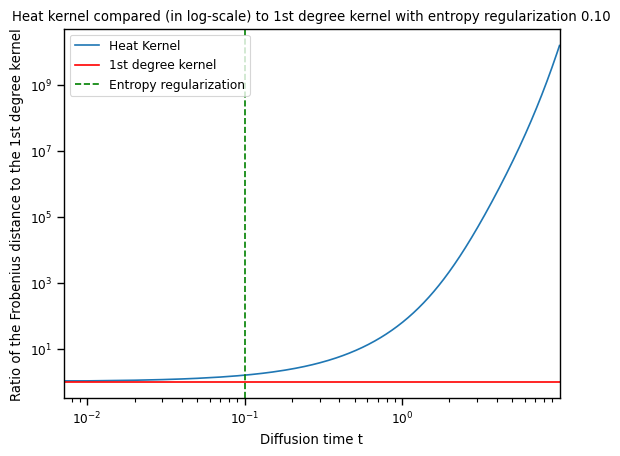

In [11]:
plt.figure()
plt.plot(diffusion_times,frob_dist,label='Heat Kernel')
plt.axhline(y = 1, color = 'r', linestyle = '-',label='1st degree kernel') 
plt.axvline(x = entropy_reg, color ='g', linestyle = '--', label ='Entropy regularization')
plt.xlabel("Diffusion time t")
plt.xscale('log')
plt.xlim(np.min(diffusion_times),np.max(diffusion_times))
plt.ylabel("Ratio of the Frobenius distance to the 1st degree kernel")
plt.yscale('log')
plt.legend()
plt.title("Heat kernel compared (in log-scale) to 1st degree kernel with entropy regularization %1.2f" %entropy_reg)
plt.show()

Test of the error gap as a function of the size of the graph, on random graphs

In [12]:
frob_dist = []
N = np.arange(6,100)
entropy_reg = 0.1
t = entropy_reg / 2

for n in N:
    G = gr.Graph(0,0,graph = nx.connected_watts_strogatz_graph(n,n//5+1,0.4))
    K2, dist = gr.kernel(G.G, entropy_reg=entropy_reg, deg = 2)
    norm_kern2 = np.linalg.norm(K2)
    frob_dist.append(np.trace(G.compute_heat_kernel(t).T@K2)
             /norm_kern2**2)



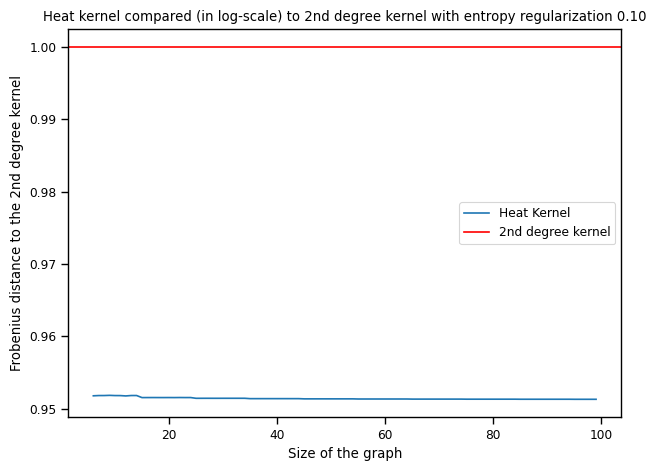

In [13]:
plt.figure()
plt.plot(N,frob_dist,label='Heat Kernel')
plt.axhline(y = 1, color = 'r', linestyle = '-',label='2nd degree kernel') 
plt.xlabel("Size of the graph")
# plt.xscale('log')
plt.ylabel("Frobenius distance to the 2nd degree kernel")
# plt.yscale('log')
plt.legend()
plt.title("Heat kernel compared (in log-scale) to 2nd degree kernel with entropy regularization %1.2f" %entropy_reg)
plt.tight_layout()
plt.show()

## Convolutional Wasserstein

In [21]:
N = 60
G = gr.Graph(0,0,graph = nx.connected_watts_strogatz_graph(N,N//5+1,0.1))

entropy_reg = 0.1
t = entropy_reg / 2

K1, dist = gr.kernel(G.G, entropy_reg=entropy_reg, deg = 1)
K2, dist = gr.kernel(G.G, entropy_reg=entropy_reg, deg = 2)
HK = G.compute_heat_kernel(t)


# Set the true Kernel function
f_kernel1 = lambda x: np.dot(K1,x)
f_kernel2 = lambda x: np.dot(K2,x)
f_heatkernel = lambda x: np.dot(HK,x)

In [27]:
# Generate distributions on the graph
n_distribs = 2

# mu = [np.random.dirichlet(np.random.rand(N)+1) for k in range(n_distribs)]

# Clustered distributions
# mu = [[0]*N for r in range(n_distribs)]
# for k in range(n_distribs):
#     nodes = np.random.randint(k*N//n_distribs+1,(k+1)*N//n_distribs,size=4)
#     for j in range(4):
#         mu[k][nodes[j]] += 1/4
        
# Weights of the nodes
a = np.ones(N)

#### Convergence of the Convolutional Wasserstein Algorithm

In [30]:
err_0_heat = []
err_1_true = []
err_1_heat = []
err_0_true = []

for _ in range(100):
    mu = [np.random.dirichlet(np.random.rand(N)+1) for k in range(n_distribs)]
    G = gr.Graph(0,0,graph = nx.connected_watts_strogatz_graph(N,N//5+1,0.1))
    
    kern_tested = f_heatkernel
    wass_conv, Err_mu_0_heat, Err_mu_1_heat = wass.convolutional_wasserstein(np.array(mu[0]), np.array(mu[1]), a, kern_tested, entropy_reg = entropy_reg)
    err_0_heat.append(Err_mu_0_heat)
    err_1_heat.append(Err_mu_1_heat)
    
    kern_tested = f_kernel2
    wass_conv, Err_mu_0_true, Err_mu_1_true = wass.convolutional_wasserstein(np.array(mu[0]), np.array(mu[1]), a, kern_tested, entropy_reg = entropy_reg)
    err_0_true.append(Err_mu_0_true)
    err_1_true.append(Err_mu_1_true)

/var/folders/j2/99bn3bfd5fq_xmh377nj_mw80000gn/T/ipykernel_17755/2721164947.py:5: RuntimeWarning: divide by zero encountered in log
  ax[0].plot(np.log(err_0_heat[i]),color = 'b',label='Heat diffusion',alpha = (i/100)**1/2)


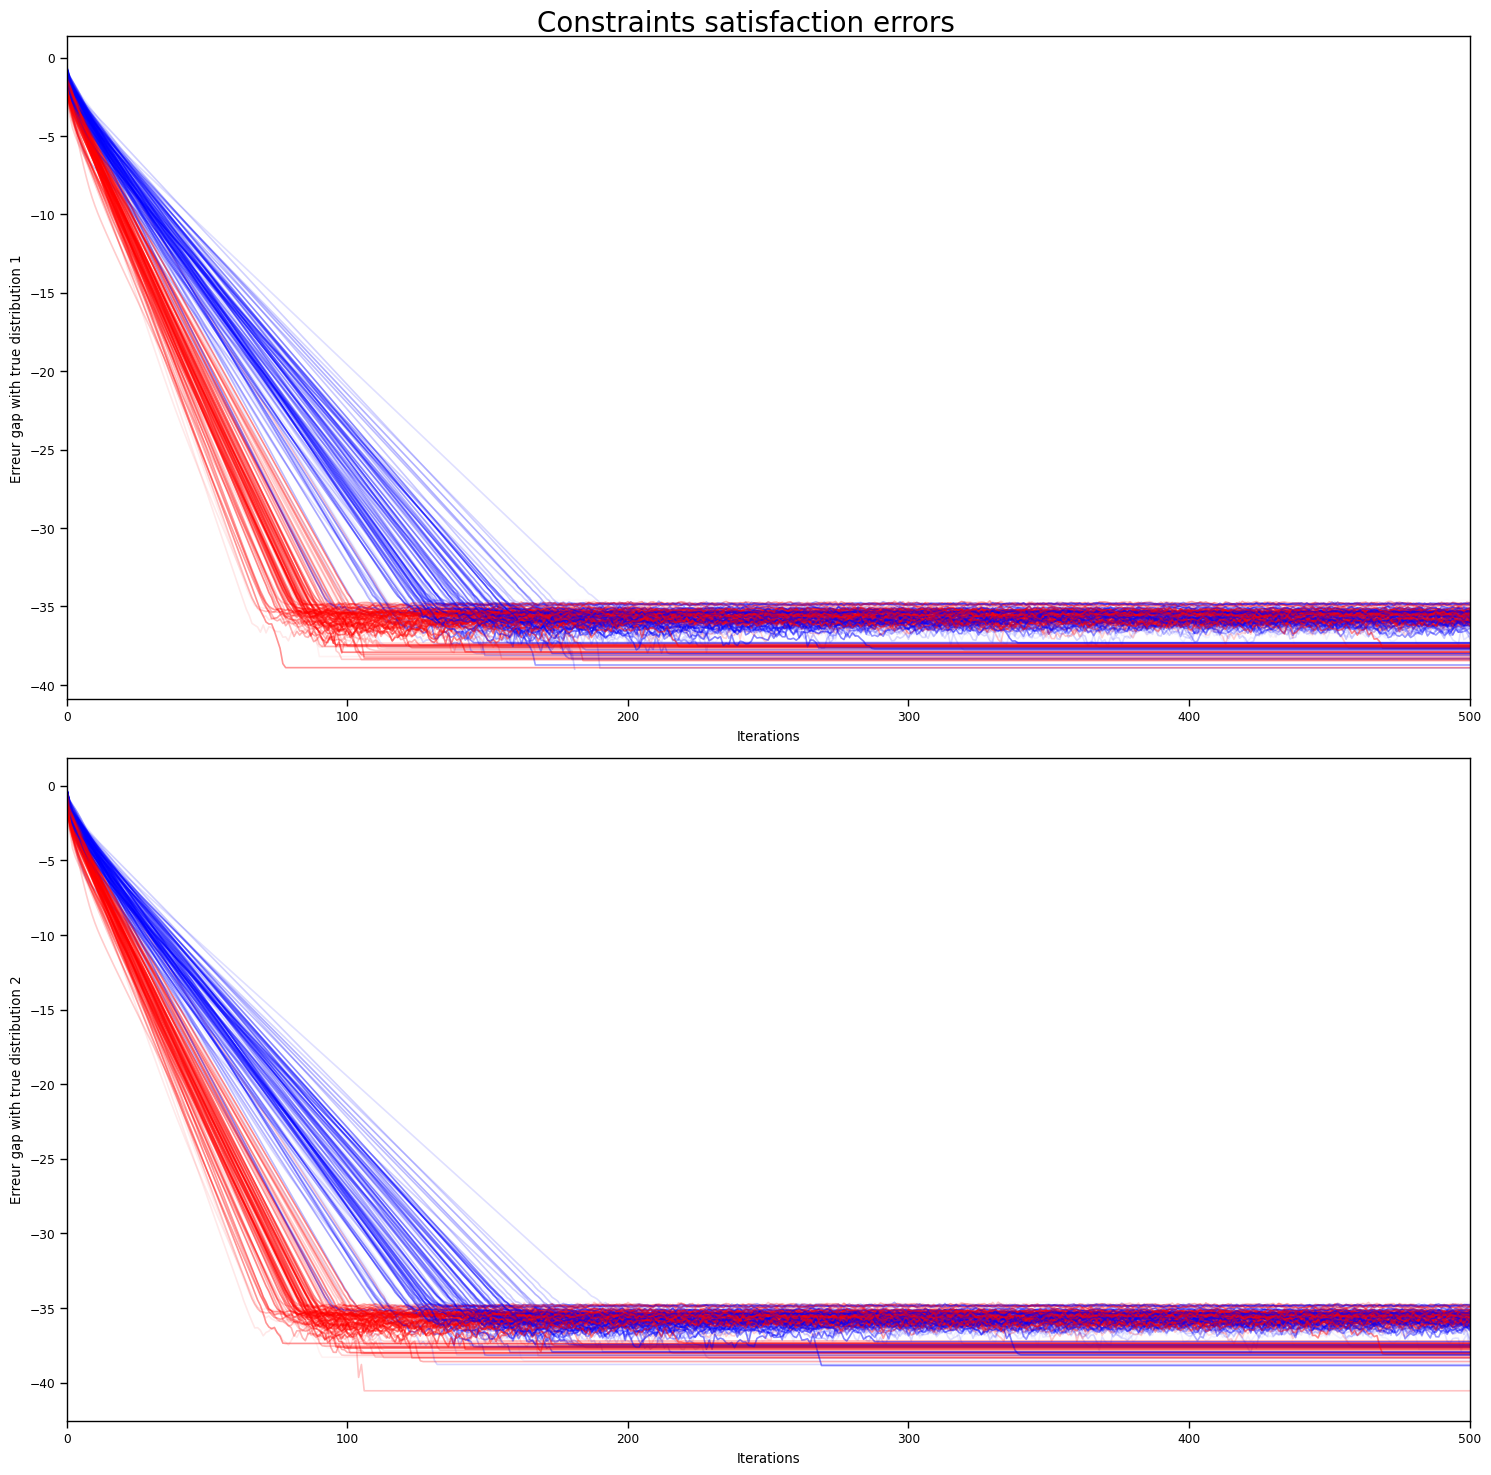

In [31]:
# Check if the coupling verify the conditions of egality with the two distributions

fig, ax = plt.subplots(2,figsize=(15,15))
for i in range(100):
    ax[0].plot(np.log(err_0_heat[i]),color = 'b',label='Heat diffusion',alpha = (i/100)**1/2)
    ax[0].plot(np.log(err_0_true[i]),color = 'r',label='2nd degree Kernel',alpha = (i/100)**1/2)
    ax[1].plot(np.log(err_1_heat[i]),color = 'b', label = 'Heat diffusion',alpha = (i/100)**1/2)
    ax[1].plot(np.log(err_1_true[i]),color = 'r',label='2nd degree Kernel',alpha = (i/100)**1/2) 
ax[0].set_xlim(0,500)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Erreur gap with true distribution 1")
# ax[0].legend()

ax[1].set_xlim(0,500)
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Erreur gap with true distribution 2")
# ax[1].legend()
fig.suptitle('Constraints satisfaction errors',size=20)

plt.tight_layout()
plt.show()

#### Wasserstein distance as a function of regularization

In [25]:
# Check the distance between the order 2 Wasserstein distance calculated with the true kernel or the heatkernel
# As a function of the number of Sinkhorn iterations


entropies = np.arange(0.01,1,0.01)
overall_wass_conv_true = []
overall_wass_conv_heat = []
mu = [np.random.dirichlet(np.random.rand(N)+1) for k in range(2)]


for _ in range(100):

    G = gr.Graph(0,0,graph = nx.connected_watts_strogatz_graph(N,N//5+1,0.1))

    
    wass_conv_true = []
    wass_conv_heat = []
    
    for entropy_reg in entropies:

        K2, dist = gr.kernel(G.G, entropy_reg=entropy_reg, deg = 2)
        HK = G.compute_heat_kernel(entropy_reg/2)

        f_kernel2 = lambda x: np.dot(K2,x)
        f_heatkernel = lambda x: np.dot(HK,x)

        wass_conv1, Err_mu_0_true, Err_mu_1_true = wass.convolutional_wasserstein(np.array(mu[0]), np.array(mu[1]), a, f_kernel2, 
                                                                                entropy_reg = entropy_reg,n_iter=100)
        wass_conv_true.append(wass_conv1**2)
        wass_conv2, Err_mu_0, Err_mu_1 = wass.convolutional_wasserstein(np.array(mu[0]), np.array(mu[1]), a,f_heatkernel, 
                                                                    entropy_reg = entropy_reg,n_iter=100)
        wass_conv_heat.append(wass_conv2**2)
    
    overall_wass_conv_true.append(wass_conv_true)
    overall_wass_conv_heat.append(wass_conv_heat) 
        

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


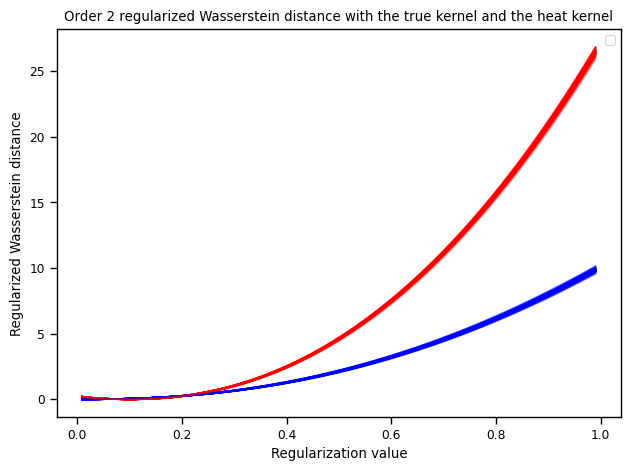

In [26]:
plt.figure()
for i in range(100):
    plt.plot(entropies,overall_wass_conv_heat[i],color = 'b',alpha = (i/100)**1/2)
    plt.plot(entropies,overall_wass_conv_true[i],color = 'r',alpha = (i/100)**1/2)
plt.xlabel("Regularization value")
# plt.xscale('log')
plt.ylabel("Regularized Wasserstein distance")
# plt.yscale('log')
plt.legend()
plt.title("Order 2 regularized Wasserstein distance with the true kernel and the heat kernel")
plt.tight_layout()
plt.show()

## Entropy Regularization

In [99]:
N = 60
R = 5
G = gr.Graph(R,N)
a = np.ones(N)
entropy_reg = 0.2
t = entropy_reg / 2

K2, dist = gr.kernel(G.G, entropy_reg=entropy_reg, deg = 2)
HK = G.compute_heat_kernel(t)


# Set the true Kernel function
f_kernel2 = lambda x: np.dot(K2,x)
f_heatkernel = lambda x: np.dot(HK,x)

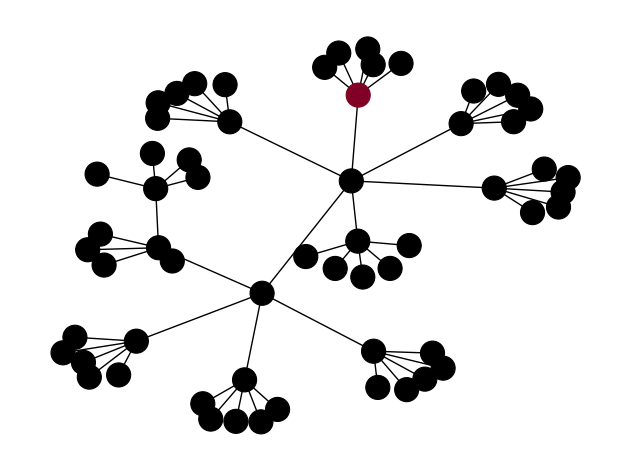

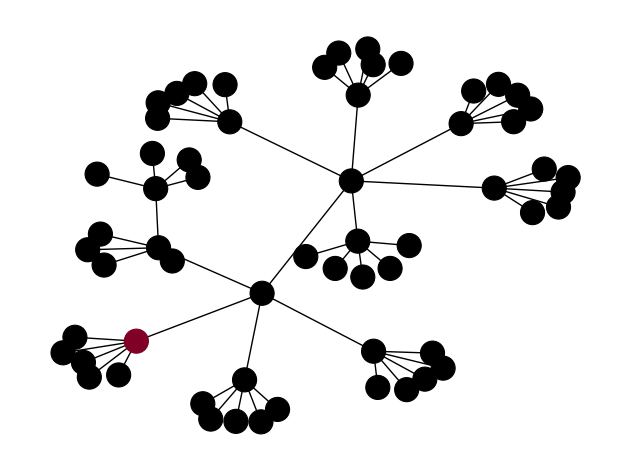

In [93]:
# Diract distributions
mu_1 = np.zeros(N)
mu_1[4] = 1
mu_0 = np.zeros(N)
mu_0[8] = 1

gr.plot(G.G,mu_0)
gr.plot(G.G,mu_1)

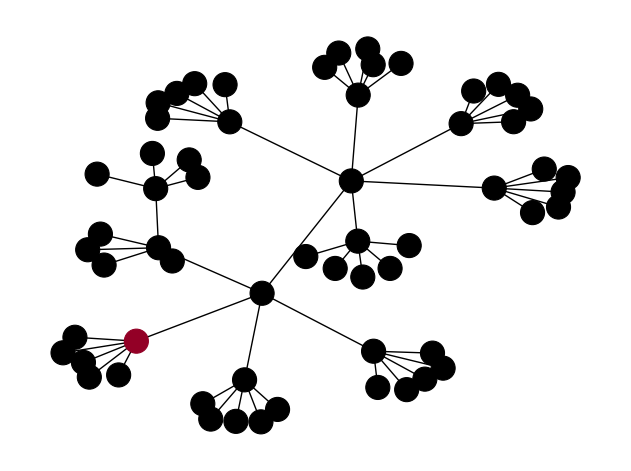

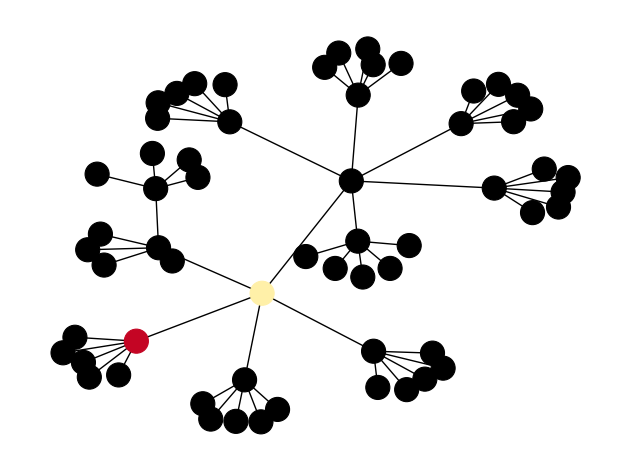

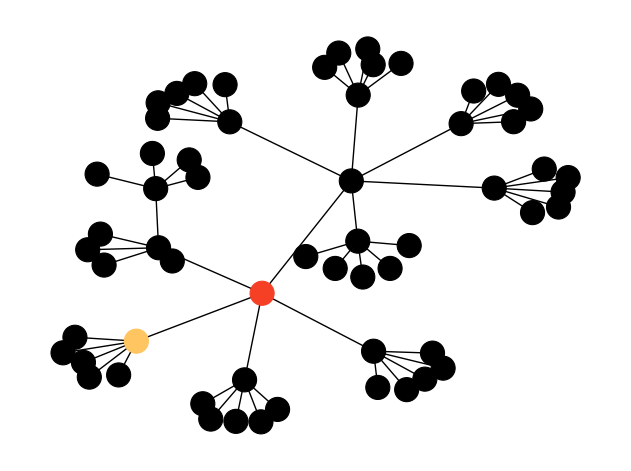

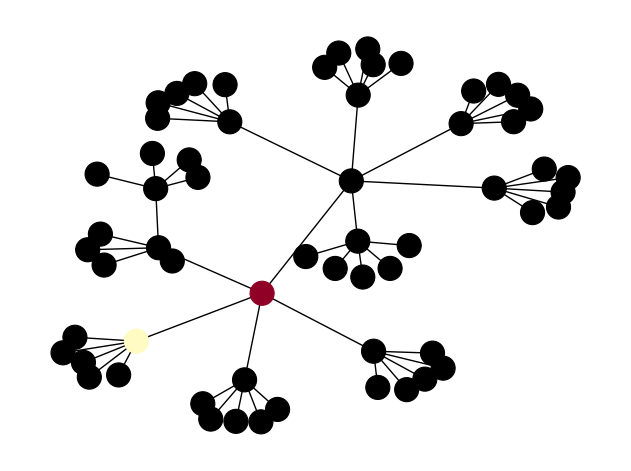

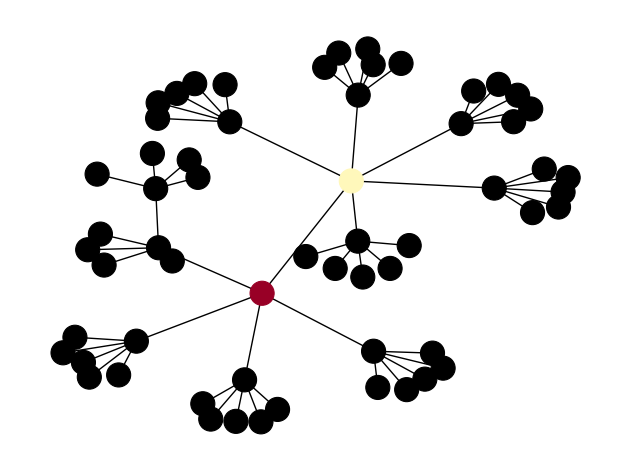

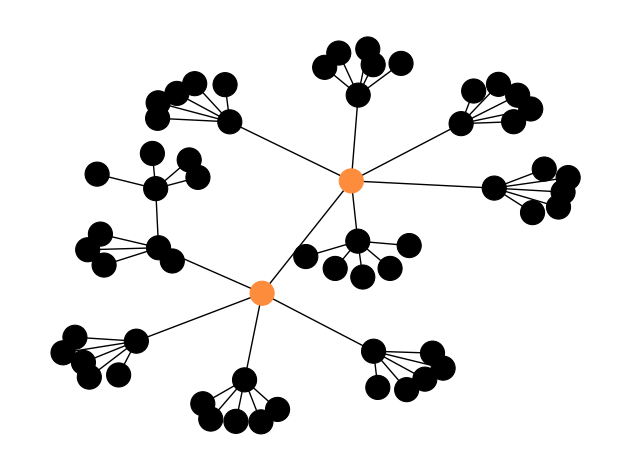

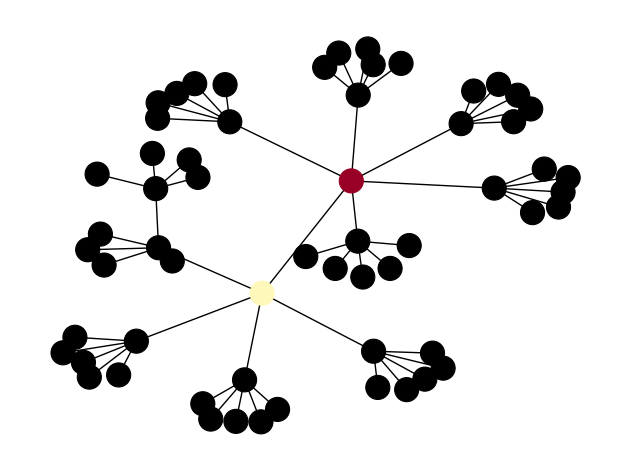

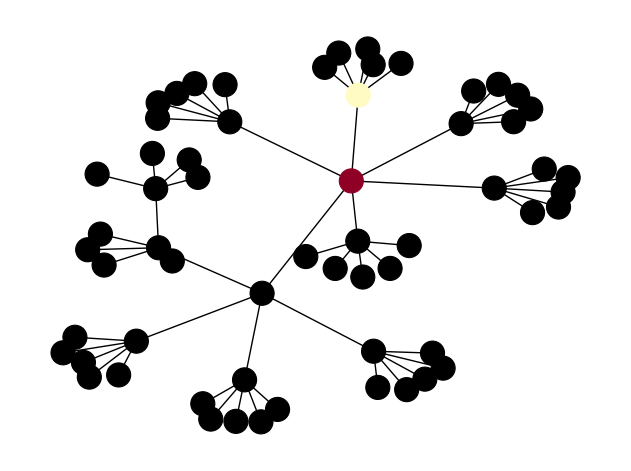

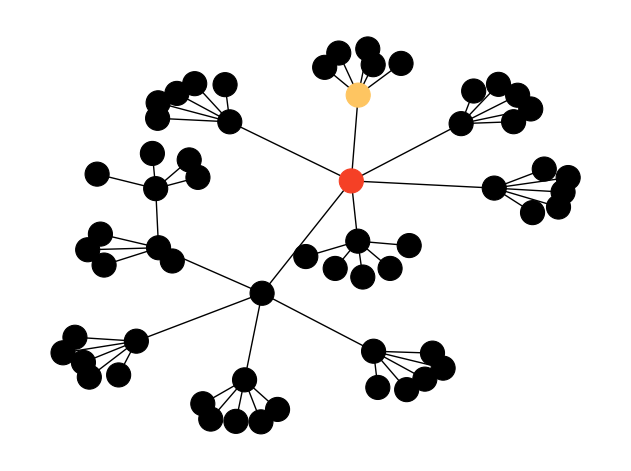

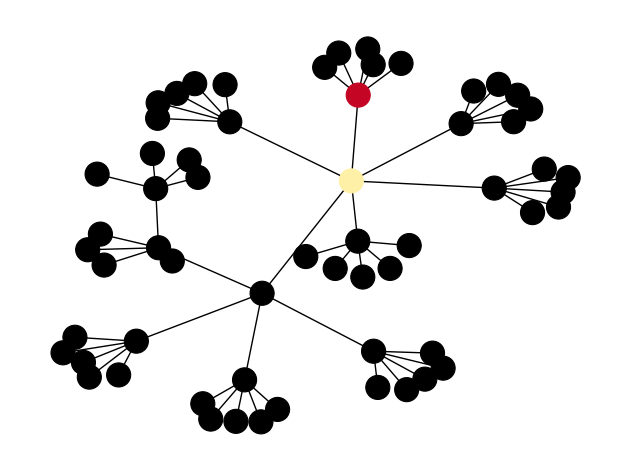

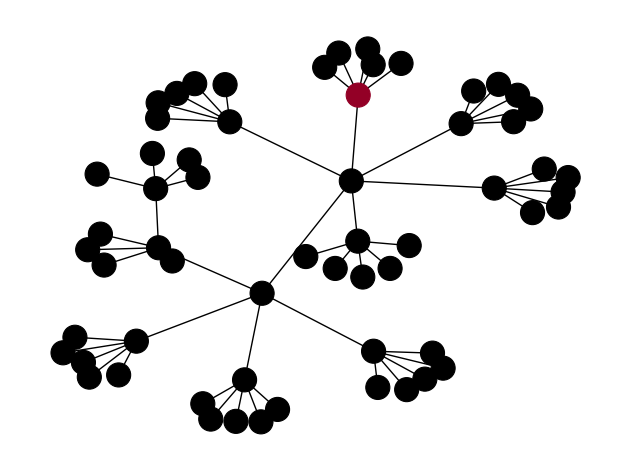

In [110]:
# Linear interpolation between two distributions

for t in range(0,11):
    barycenter_mu, error = wass.wasserstein_barycenter(np.array([mu_0,mu_1]).T, a, f_kernel2,lambd=[t/10,1-t/10])
    gr.plot(G.G,barycenter_mu)


## Wasserstein Barycenter

In [102]:
N = 60
R = 5
G = gr.Graph(R,N)
a = np.ones(N)
entropy_reg = 0.2
t = entropy_reg / 2

K2, dist = gr.kernel(G.G, entropy_reg=entropy_reg, deg = 2)

# Set the true Kernel function
f_kernel2 = lambda x: np.dot(K2,x)

mu = [[0]*N for r in range(6)]
for k in range(6):
    mu[k][np.random.randint(0,N)] = 1
        


barycenter_mu, error = wass.wasserstein_barycenter(np.array(mu).T, a, f_kernel2)

/var/folders/j2/99bn3bfd5fq_xmh377nj_mw80000gn/T/ipykernel_17755/2892036798.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(error))


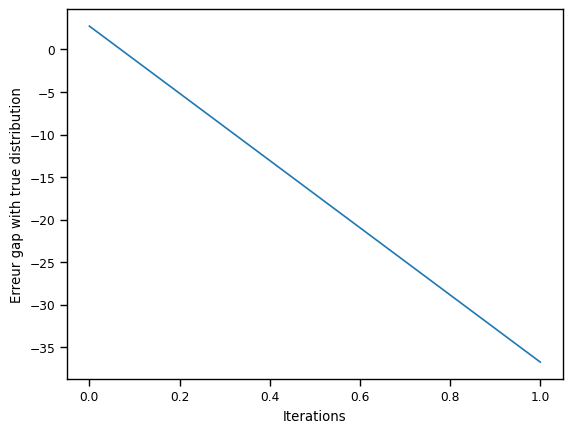

In [111]:
plt.figure()
plt.plot(np.log(error))
plt.xlabel("Iterations")
plt.ylabel("Erreur gap with true distribution")
plt.show()

Distribution:  0


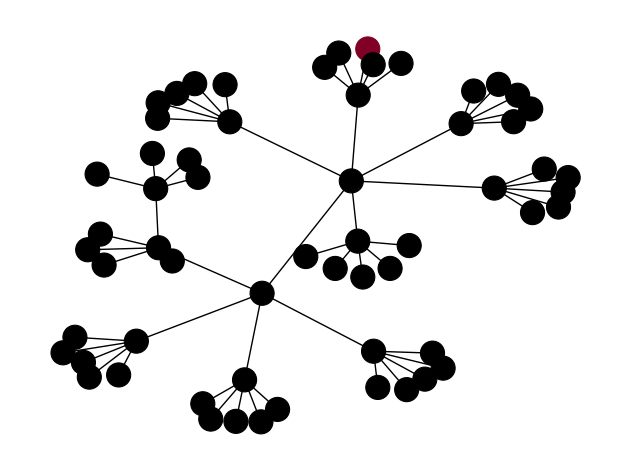

Distribution:  1


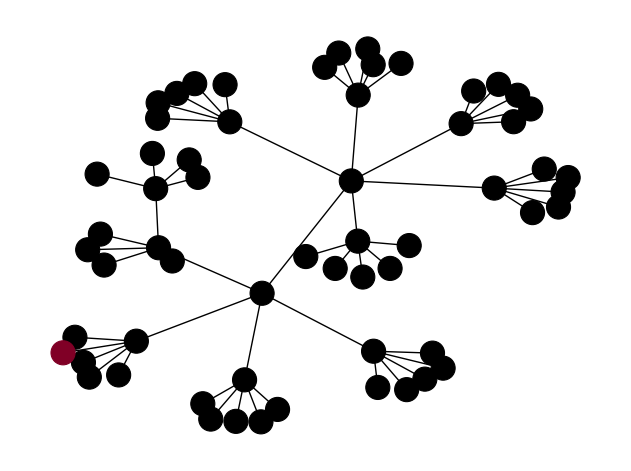

Distribution:  2


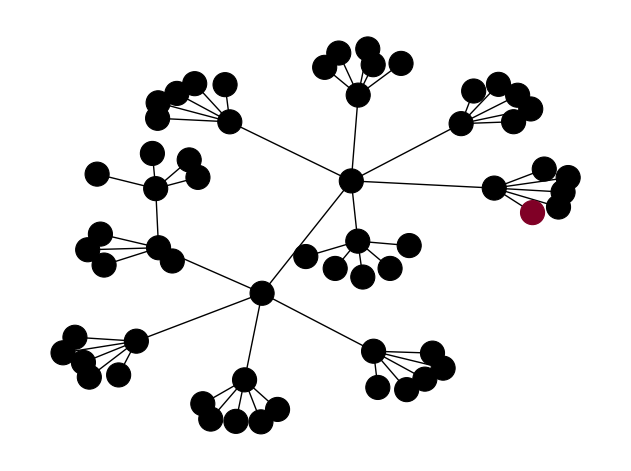

Distribution:  3


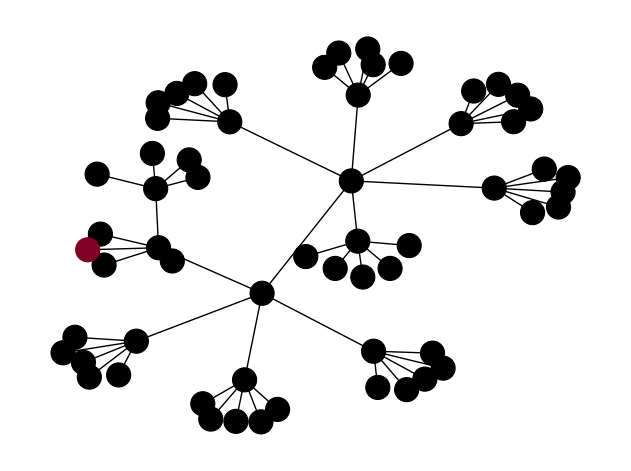

Distribution:  4


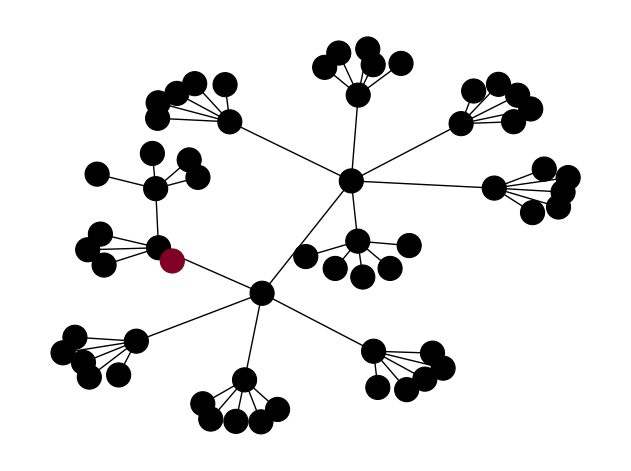

Distribution:  5


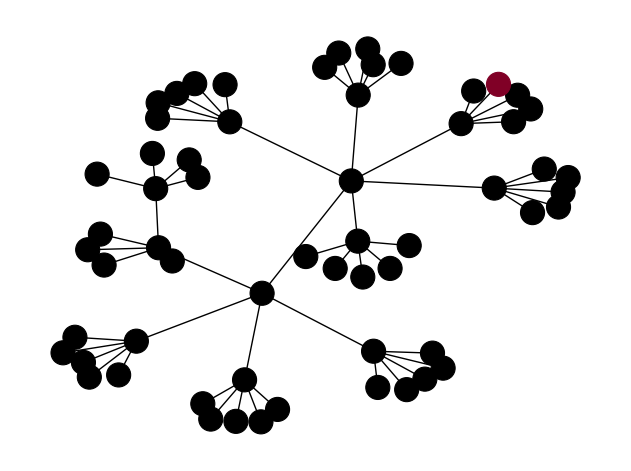

Distribution Barycentre


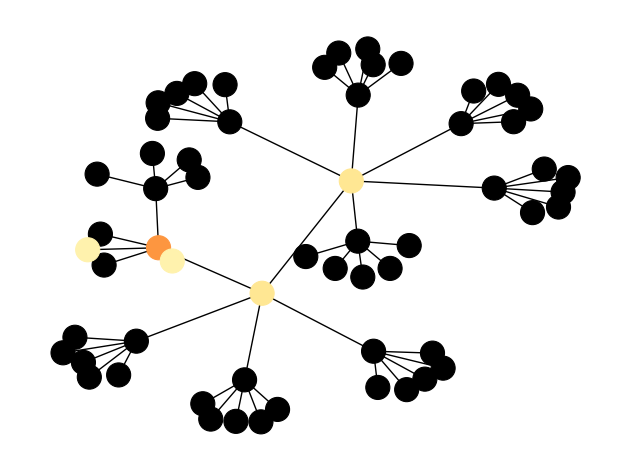

In [104]:
for (compt,mu_) in enumerate(mu):
    print("Distribution: ",compt)
    gr.plot(G.G,mu_)
    
print("Distribution Barycentre")
gr.plot(G.G,barycenter_mu)

## Images

/var/folders/j2/99bn3bfd5fq_xmh377nj_mw80000gn/T/ipykernel_17755/635625567.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  a = imageio.imread("../data/" + names[i] + ".bmp") # ,N)


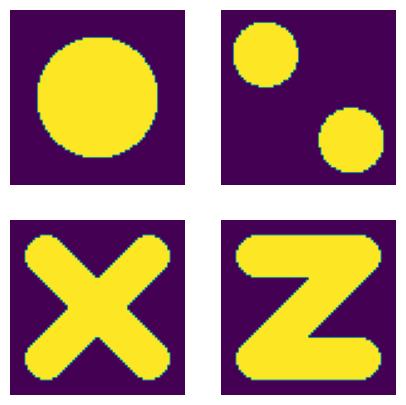

In [116]:
def reconstruct_image(N,vect):
    image = np.zeros((N,N))
    for i in range(N):
        image[i,:]= vect[i*N:(i+1)*N]
    return image



normalize = lambda p: p/np.sum(p)
rescale = lambda x: (x-x.min())/(x.max()-x.min())
N = 70
names = ['disk','twodisks','letter-x','letter-z']
vmin = .01
A = np.zeros((N*N,len(names)))
for i in range(len(names)):
    a = imageio.imread("../data/" + names[i] + ".bmp") # ,N) 
    a = normalize(rescale(a)+vmin)
    A[:,i] = a.flatten()
R = len(names)
plt.figure(figsize=(5,5))

for i in range(R):
    plt.subplot(2,2,i+1)
    plt.imshow(reconstruct_image(N,A[:,i]))
    plt.axis('off')
    
    

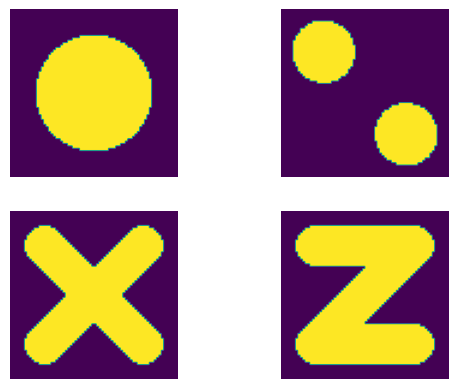

In [123]:
entropy_reg = 0.001
t = np.linspace(0,1,N)
[Y,X] = np.meshgrid(t,t)
K1 = np.exp(-(X-Y)**2/entropy_reg)
K = lambda x: np.dot(np.dot(K1,reconstruct_image(N,x)),K1).flatten()
a = np.ones(N*N)

target_mu, error = wass.wasserstein_barycenter(A[:,:], a, Kernel = K)

for i in range(R):
    plt.subplot(2,2,i+1)
    plt.imshow(reconstruct_image(N,A[:,i]))
    plt.axis('off')

(-0.5, 69.5, 69.5, -0.5)

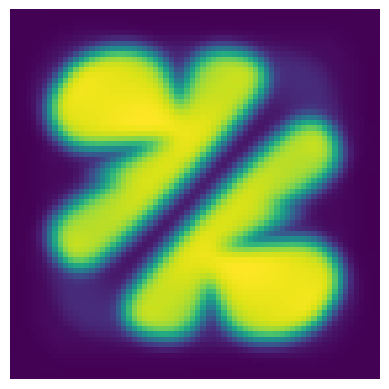

In [124]:
plt.imshow(reconstruct_image(N,target_mu))
plt.axis('off')